# Applying Data Science Model Development (LSTM)

## 1. Preprocess the data

In [1]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

C:\Users\teppe\anaconda3\envs\test_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("Final_v2_processed.csv")
test_df = pd.read_csv("Final_test_v2_processed.csv")

# Convert 'addr_state' from string to numeric
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.fit_transform(test_df["addr_state"])

# Replace 'df' with your actual DataFrame
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Extract features and target
X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Standardize features
#scaler = StandardScaler()
#X_test = scaler.transform(X_test)

# Reshape for LSTM input: (samples, sequence_length, input_size)
X = X.reshape(X.shape[0], 1, X.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom Dataset class
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # long type for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset instances
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)

## 2. Define the LSTM model

In [3]:
# === Step 2: Define LSTM Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)             # LSTM output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out

## 3. Tune hyperparameters by Optuna

In [4]:
# === Step 3: Optuna Hyperparameter Tuning ===
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = LSTMClassifier(input_size=X.shape[2], hidden_size=hidden_size,
                           num_layers=num_layers, num_classes=2, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    # F1 score as target
    return 1 - f1_score(y_true, y_pred, average="weighted")

# Run Optuna
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-28 22:05:58,198] A new study created in memory with name: no-name-f144abd4-c515-4ea2-a936-e2a9a640a10f
C:\Users\teppe\anaconda3\envs\test_env\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2932516050653472 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2025-04-28 22:10:06,611] Trial 0 finished with value: 0.24116101152885172 and parameters: {'hidden_size': 84, 'num_layers': 1, 'dropout': 0.2932516050653472, 'lr': 0.0028339080373308762, 'batch_size': 32}. Best is trial 0 with value: 0.24116101152885172.
[I 2025-04-28 22:13:33,385] Trial 1 finished with value: 0.03373164143212215 and parameters: {'hidden_size': 90, 'num_layers': 3, 'dropout': 0.24807442778138444, 'lr': 0.000793931891638038, 'batch_size': 128}. Best is trial 1 with value: 0.03373164143212215.
[I 2025-04-28 22:16:35,316] Trial 

Best hyperparameters: {'hidden_size': 94, 'num_layers': 3, 'dropout': 0.08936559070920103, 'lr': 0.00018558262996830192, 'batch_size': 32}


## 4. Re-learn with the optimized parameters

In [5]:
# === Step 4: Train Final Model with Best Params ===
#batch_size = best_params['batch_size']
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = LSTMClassifier(input_size=X.shape[2],
                       hidden_size=best_params['hidden_size'],
                       num_layers=best_params['num_layers'],
                       num_classes=2,
                       dropout=best_params['dropout']
                       )

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Initialize early stopping variables
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Lists to store loss per epoch
train_losses = []
val_losses = []

# Updated training loop with loss tracking
for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    predicted_labels = []
    prob_0 = []  # Probability for class 0 (loan approved)
    prob_1 = []  # Probability for class 1 (loan rejected)

    running_val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)             # Probabilities for each class
            _, preds = torch.max(probs, 1)                    # Get predicted class labels (0 or 1)

            loss = criterion(outputs, y_batch)                # Use the original y_batch here!
            running_val_loss += loss.item()

            predicted_labels.extend(preds.cpu().numpy())
            prob_0.extend(probs[:, 0].cpu().numpy())  # Class 0 (loan approved)
            prob_1.extend(probs[:, 1].cpu().numpy())  # Class 1 (loan rejected)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check early stopping condition
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        early_stop = True
        break

# After training, optionally load the best model weights
#model.load_state_dict(best_model_state)

Epoch 1 - Train Loss: 0.2236, Val Loss: 0.1080
Epoch 2 - Train Loss: 0.1335, Val Loss: 0.1095
Epoch 3 - Train Loss: 0.1258, Val Loss: 0.0999
Epoch 4 - Train Loss: 0.1212, Val Loss: 0.0953
Epoch 5 - Train Loss: 0.1172, Val Loss: 0.0992
Epoch 6 - Train Loss: 0.1165, Val Loss: 0.1121
Epoch 7 - Train Loss: 0.1143, Val Loss: 0.0941
Epoch 8 - Train Loss: 0.1136, Val Loss: 0.0944
Epoch 9 - Train Loss: 0.1114, Val Loss: 0.0945
Epoch 10 - Train Loss: 0.1104, Val Loss: 0.0940
Epoch 11 - Train Loss: 0.1090, Val Loss: 0.0919
Epoch 12 - Train Loss: 0.1086, Val Loss: 0.0925
Epoch 13 - Train Loss: 0.1087, Val Loss: 0.1038
Epoch 14 - Train Loss: 0.1075, Val Loss: 0.1139
Epoch 15 - Train Loss: 0.1069, Val Loss: 0.0899
Epoch 16 - Train Loss: 0.1062, Val Loss: 0.0901
Epoch 17 - Train Loss: 0.1062, Val Loss: 0.0929
Epoch 18 - Train Loss: 0.1057, Val Loss: 0.0879
Epoch 19 - Train Loss: 0.1054, Val Loss: 0.0867
Epoch 20 - Train Loss: 0.1047, Val Loss: 0.0879


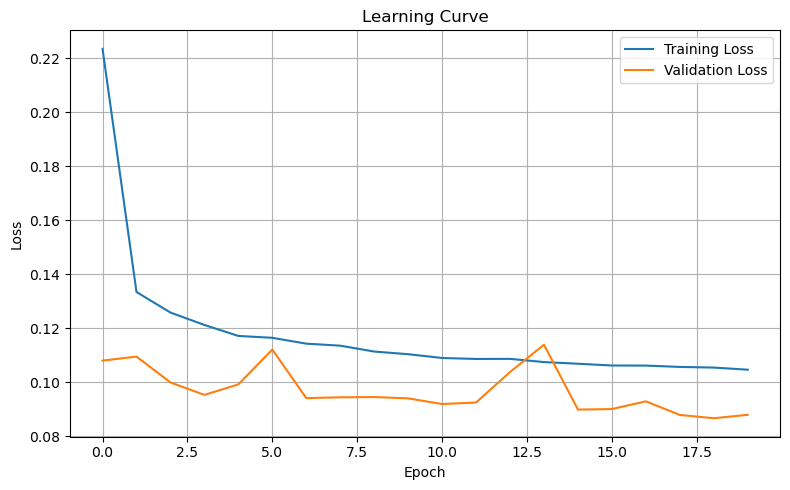

In [6]:
# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Combine everything into a nice table
results_df = pd.DataFrame({
    "true_label": y_val,
    "predicted_label": predicted_labels,
    "probability_0": prob_0,   # loan_status = 0
    "probability_1": prob_1    # loan_status = 1
})

# Preview
results_df.to_csv("results.csv")
results_df

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.985528,0.014472
1,0,0,0.988244,0.011756
2,0,0,0.996152,0.003848
3,0,0,0.988219,0.011781
4,0,0,0.991969,0.008031
...,...,...,...,...
34851,1,1,0.000065,0.999935
34852,0,0,0.970741,0.029259
34853,0,0,0.965554,0.034446
34854,0,0,0.884520,0.115480


## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.9864
F1-Score:    0.8998
Precision:   0.9262
Recall:      0.8749
Confusion Matrix:
[[114681   1613]
 [  2894  20235]]
Mean G-Mean: 0.9288


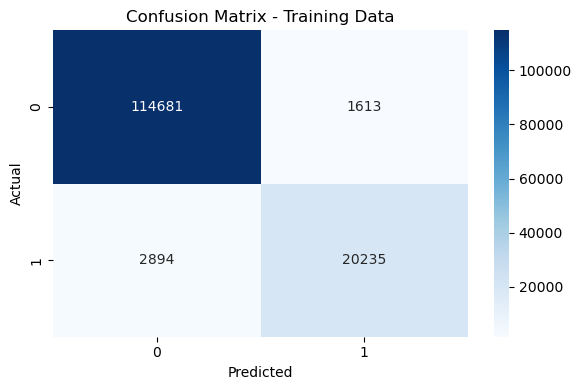


--- Evaluation on Validation Data ---
AUC-ROC:     0.9863
F1-Score:    0.8978
Precision:   0.9207
Recall:      0.8761
Confusion Matrix:
[[28642   436]
 [  716  5062]]
Mean G-Mean: 0.9289


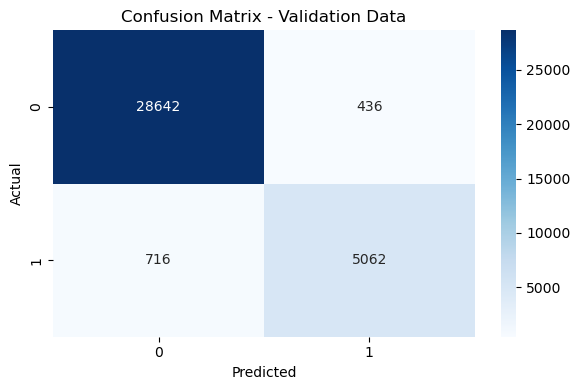


--- Evaluation on Test Data ---
AUC-ROC:     0.9671
F1-Score:    0.7981
Precision:   0.7581
Recall:      0.8425
Confusion Matrix:
[[113987   3274]
 [  1918  10259]]
Mean G-Mean: 0.9050


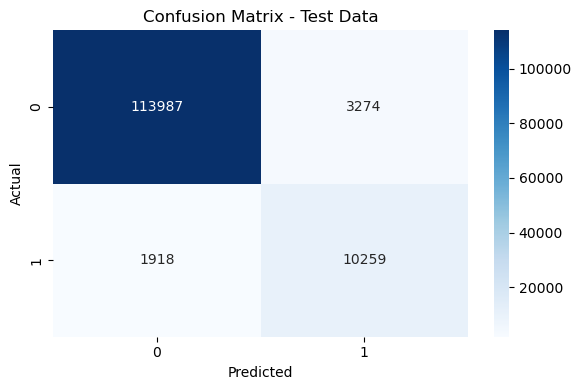

In [8]:
# === Step 5: Evaluation Metrics ===
test_loader = DataLoader(test_dataset, batch_size=batch_size)

def evaluate_model(model, data_loader, dataset_name=""):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            #_, preds = torch.max(outputs, 1)
            preds = (probs > 0.3).int() # set the threshold as 0.3 to gain recall score
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
            y_prob.extend(probs.numpy())

    # Compute metrics
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Compute G-mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Run on both datasets
evaluate_model(model, train_loader, "Training Data")
evaluate_model(model, val_loader, "Validation Data")
evaluate_model(model, test_loader, "Test Data")

## 6. Save the model

In [9]:
# === Step 6: Save Model and Scaler ===
# Save both model weights and best_params dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': best_params
}, "lstm_model_full.pth")

# Convert dict to DataFrame (1 row)
params_df = pd.DataFrame([best_params])

# Save to CSV
params_df.to_csv("best_params.csv", index=False)

# Save scaler used for input normalization
#joblib.dump(scaler, "scaler.pkl")

In [10]:
# === Optional: Load Model and Scaler Later ===
# Read CSV back into dict
loaded_params_df = pd.read_csv("best_params.csv")
best_params = loaded_params_df.iloc[0].to_dict()

# Convert float strings to actual int if needed
# (because CSV stores all as float by default)
best_params['hidden_size'] = int(best_params['hidden_size'])
best_params['num_layers'] = int(best_params['num_layers'])
best_params['batch_size'] = int(best_params['batch_size'])

## Optional: load the model

In [11]:
# Load both weights and structure
#checkpoint = torch.load("lstm_model_full.pth")
#params = checkpoint['model_params']

#model = LSTMClassifier(input_size=X.shape[2],
                       #hidden_size=params['hidden_size'],
                       #num_layers=params['num_layers'],
                       #num_classes=2,
                       #dropout=params['dropout'])
#model.load_state_dict(checkpoint['model_state_dict'])
#model.eval()
# scaler = joblib.load("scaler.pkl")